In [ ]:
%%bash

## generate nested directories for different values of bias, dispersion and r0

# cd /Users/evogytis/Dropbox/Jupyter_notebooks/MCMC/;
for r in `seq 0.5 0.025 1.1`;
    do for k in 0.004 0.02 0.1 0.5 1.0;
        do for b in 1 2 3;
            do 
                R=$(printf 'r_%0.3f' $r);
                K=$(printf 'k_%0.3f' $k);
                mkdir -p b_$b/$K/$R;
            done;
        done;
    done;

In [ ]:
%%julia
### revisions cell - generate clusters under different values of dispersion, on a rougher r0 grid and with fewer replicates

## note that Julia has to be installed and available on $PATH and julia made available as a magic in Jupyter
## also make sure these packages are installed with Pkg.add("PACKAGE") in Julia:
using StatsBase
using Distributions
using StatsFuns
using Formatting

function clusterLikelihood(r::Float64,k::Float64,j::Int)
    """
    Likelihood derived from:
    Blumberg S, Lloyd-Smith JO (2013) 
    Inference of R0 and Transmission Heterogeneity from the Size Distribution of Stuttering Chains. 
    PLOS Computational Biology 9(5): e1002993. 
    https://doi.org/10.1371/journal.pcbi.1002993
    """
    
    c1 = lgamma(k*j+j-1)
    c2 = lgamma(k*j)
    c3 = lgamma(j+1)
    c4 = log((r/k)^(j-1))
    c5 = log((1+r/k)^(k*j+j-1))
    
    L=BigFloat(( c1 - ( c2 + c3 ) ) + ( c4 - c5 ))
    if isnan(L)
        L=-Inf
    elseif isinf(L)
        L=-Inf
    end
    return L
end;

function generateWeights(r::Float64,k::Float64,maxClusterSize::Int)
    """
    Generate sampling probabilities for clusters of a given size at given r0 and k.
    """
    raw=[e^clusterLikelihood(r,k,m) for m in 1:maxClusterSize] ## generate probability for sampling a cluster of a given size at different levels of r0 and k
    masked=[x for x in raw if isinf(x)==false] ## collect probabilities that aren't infinite
    sraw=1-sum(masked) ## assign remainder probability to class greater than maxClusterSize
    append!(raw,sraw) ## add probability
    
    probs=[]
    for x in raw
        if isinf(x) || isnan(x) ## if probability is infinite or NaN - make it 0.0
            append!(probs,0.0)
        else
            append!(probs,x)
        end
    end
    
    return probs
end;
        
function generateClusters(r::Float64,k::Float64,N::Int,loc_weights=[]::Array)
    """
    Generate clusters at a given r0 and k until an outbreak of size N is reached.
    Can optionally provide sampling probabilities if they were pre-computed.
    """
    if length(loc_weights)==0 || sum(loc_weights)<0 ## if sampling probabilities were not provided
        loc_weights=generateWeights(r,k,N) ## generate sampling probabilities
    end

    clusters=sample(1:N+1, WeightVec(map(Float64,loc_weights)),N) ## draw N clusters at random
    if clusters[1]>N ## if first generated cluster greater than maximum outbreak size
        clusters=[N] ## first generated cluster is of size N
    else
        clusters=[clusters[i] for i in 1:length(clusters) if sum(clusters[1:i])<=N] ## generate clusters until just below outbreak size N
        append!(clusters,N-sum(clusters)) ## add remainder cluster
    end
    
    return clusters,loc_weights
end;

function MultivariateHypergeometricSampleBias(n::Int,D::Array,bias::Float64)
    N = sum(D) ## total cases = pool
    m = length(D) ## indexing
    n_otr = N-D[1] ## things left to sequence
        
    if length(D)==1
        x=[n]
    else
        x = zeros(Int64,m)
        x[1] = rand(Hypergeometric(D[1],n_otr,n)) ## starting draw
        for i = 2:m-1
            n_otr = n_otr-D[i] ## total pool reduced after sequencing/testing
            n = n-x[i-1] ## fewer resources left to sequence
            
            HGD=Hypergeometric(D[i],n_otr,n)
            weights=[w^bias for w in pdf(HGD,0:n)]
            x[i] = sample(0:n,WeightVec(weights/sum(weights))) ## biased draws from hypergeometric
        end
        x[m] = n-x[m-1]
    end
    return x
end;
    
function clusterProbBias(seqN::Int,r::Float64,k::Float64,N::Int,reps::Int,bias::Float64)
    ws=generateWeights(r,k,N) ## generate probabilities
    case_clusters=[generateClusters(r,k,N,ws)[1] for w = 1:reps] ## generate replicated clusters
    sequence_clusters=[MultivariateHypergeometricSampleBias(seqN,C,float(bias)) for C in case_clusters]
    return case_clusters,sequence_clusters
end;

human_sequences=174
human_cases=2000
human_clusters=[7, 2, 1, 1, 1, 1, 1, 19, 1, 1, 3, 1, 29, 1, 1, 1, 2, 1, 1, 1, 1, 1, 6, 18, 1, 1, 1, 1, 1, 2, 2, 3, 5, 2, 1, 1, 4, 1, 1, 15, 1, 4, 13, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]

reps=2000 ## number of replicate simulations
for bias in 1:3 ## bias values 
    for r = 0.5:0.025:1.05 ## R0 values
        for k = [0.004, 0.02, 0.1, 0.5, 1.0] ## dispersion values
            R=@sprintf("r_%0.3f", r)
            K=@sprintf("k_%0.3f", k)
            B="b_$bias"
            samples=open("$B/$K/$R/MERS_epi_$reps.txt","w")
            cases,sequences=clusterProbBias(human_sequences,r,k,human_cases,reps,Float64(bias))
            
            for (s,c) in zip(cases,sequences)
                out = @sprintf "%s\t%s\n" s c
                write(samples,out)
            end;
            close(samples)
        end;
    end;
end;

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import re
from matplotlib import gridspec
import matplotlib.patheffects as path_effects
from IPython.display import HTML
from scipy.stats import gaussian_kde
from scipy.stats import hypergeom
from scipy.stats import moment

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

path='<iframe style="border: 0; width: 400px; height: 208px;" src="https://bandcamp.com/EmbeddedPlayer/album=2576460848/size=large/bgcol=333333/linkcol=ffffff/artwork=small/track=884987069/transparent=true/" seamless><a href="http://skeldos.bandcamp.com/album/spaudai-imprints">Ispaudai // Imprints by Skeldos</a></iframe>'

def hpd(data, level):
    """
    Return highest posterior density interval from a list,
    given the percent posterior density interval required.
    """
    d = list(data)
    d.sort()

    nData = len(data)
    nIn = int(round(level * nData))
    if nIn < 2 :
        return None
    #raise RuntimeError("Not enough data. N data: %s"%(len(data)))
 
    i = 0
    r = d[i+nIn-1] - d[i]
    for k in range(len(d) - (nIn - 1)) :
        rk = d[k+nIn-1] - d[k]
        if rk < r :
            r = rk
            i = k

    assert 0 <= i <= i+nIn-1 < len(d)
 
    return (d[i], d[i+nIn-1])

print 'Done!'
HTML(path)

Done!


In [2]:
log_path='/Users/evogytis/Documents/MERS_2.0/clean/analyses/beast/coal/MERS_274_sCoal.combined.subtrees'
posts={}
empirical_clusters=[]
for line in open(log_path,'r'):
    l=line.strip('\n').split('\t')
    if 'state' not in l:
        empirical_clusters.append([stree.count(',')+1 for stree in l])
        
posts['mean']=map(np.mean,empirical_clusters)
posts['std']=map(np.std,empirical_clusters)
posts['third']=[moment(clusters,moment=3) for clusters in empirical_clusters]
posts['N']=map(len,empirical_clusters)

In [3]:
data={}
base='/Users/evogytis/Dropbox/Jupyter_notebooks/MERS/'
for b in os.listdir(base):
    if b.startswith('b_'):
        _,bias=b.split('_')
        bias=int(bias)
        if data.has_key(bias)==False:
            data[bias]={}
        
        for k in os.listdir('/'.join([base,b])):
            _,dispersion=k.split('_')
            if data[bias].has_key(dispersion)==False:
                data[bias][dispersion]={}
    
            for r in os.listdir('/'.join([base,b,k])):
                _,r0=r.split('_')
                if data[bias][dispersion].has_key(r0)==False:
                    data[bias][dispersion][r0]=[]
                
                try:
                    for line in open('/'.join([base,b,k,r,'MERS_epi_2000.txt']),'r'):
                        l=line.strip('\n').split('\t')
                        cases,sequences=l
                        cases=map(int,cases[1:-1].split(','))
                        sequences=map(int,sequences[1:-1].split(','))

                        data[bias][dispersion][r0].append((cases,sequences))
                except:
                    data[bias][dispersion].pop(r0)

In [4]:
hpds={}        
for idx in posts.keys():
    hpds[idx]=hpd(posts[idx],0.95)

print hpds
sl,su=hpds['std']
ml,mu=hpds['mean']
tl,tu=hpds['third']
ll,lu=hpds['N']

matches={bias:{k:{r:[] for r in data[bias][k].keys()} for k in data[bias].keys()} for bias in data.keys()}
mismatches={bias:{k:{r:[] for r in data[bias][k].keys()} for k in data[bias].keys()} for bias in data.keys()}
match_indices={bias:{k:{r:[] for r in data[bias][k].keys()} for k in data[bias].keys()} for bias in data.keys()}

norm=mpl.colors.Normalize(0.5,1.1)
for bias in data.keys():
    for k in data[bias].keys():
        for r in data[bias][k].keys():
            cs=[x[0] for x in data[bias][k][r]]
            ss=[filter(lambda w:w!=0,x[1]) for x in data[bias][k][r]]

            ## sequence cluster stats
            stds=map(np.std,ss)
            mus=map(np.mean,ss)
            meds=map(np.median,ss)
            thirds=[moment(clusters,moment=3) for clusters in ss]
            lens=map(len,ss)

            clens=map(len,cs) ## intros (case cluster lengths)

            ms=filter(lambda q:sl<stds[q]<=su and ml<mus[q]<=mu and ll<lens[q]<=lu and tl<thirds[q]<=tu,[i for i,x in enumerate(zip(stds,mus,meds,lens,thirds,clens))]) ## numbers of sequence clusters, means, stdevs, third moments

            for i in range(len(stds)):
                if i in ms:
                    matches[bias][k][r].append((stds[i],mus[i],lens[i],thirds[i],clens[i],ss[i]))
                    match_indices[bias][k][r].append(i)
                else:
                    mismatches[bias][k][r].append((stds[i],mus[i],lens[i],thirds[i],clens[i],ss[i]))
    print bias

{'std': (4.8383594556649276, 6.0237624692308618), 'mean': (2.8688524590163933, 3.6458333333333335), 'third': (415.4018181021429, 621.05591246640938), 'N': (48, 61)}
1
2
3


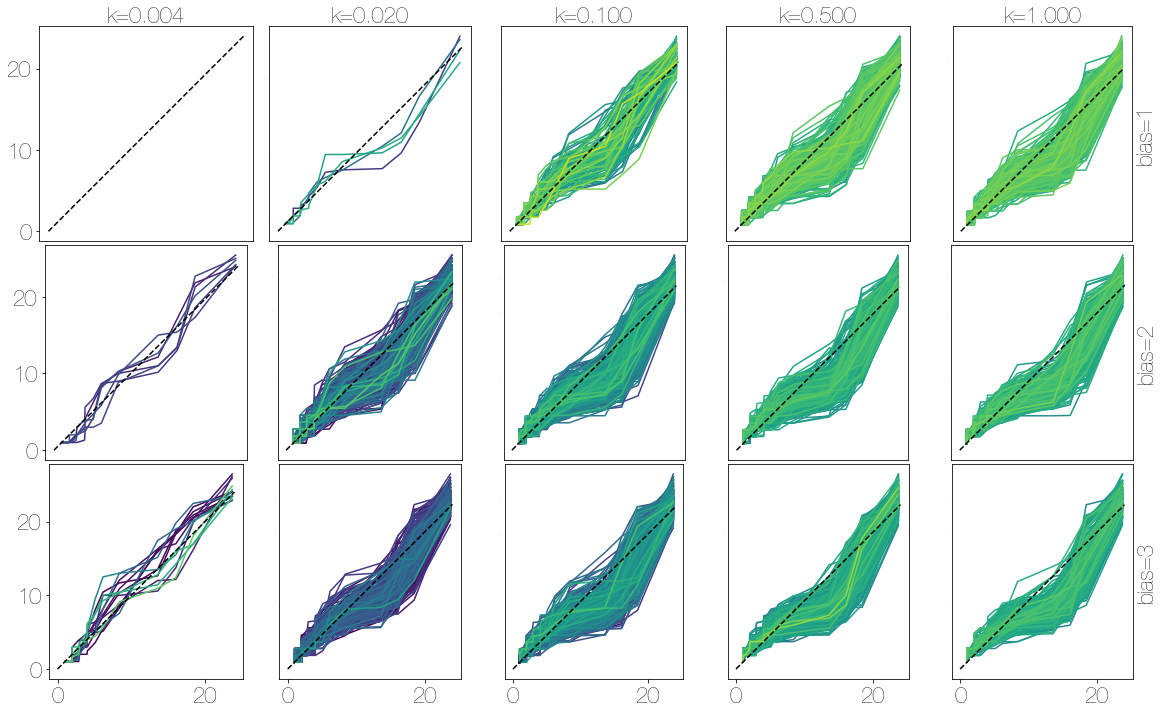

In [12]:
mcc_clusters=[7, 2, 1, 1, 1, 1, 1, 19, 1, 1, 3, 1, 29, 1, 1, 1, 2, 1, 1, 1, 1, 1, 6, 18, 1, 1, 1, 1, 1, 2, 2, 3, 5, 2, 1, 1, 4, 1, 1, 15, 1, 4, 13, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]

percentiles=np.linspace(1,99,50)
mcc_percentiles=np.percentile(mcc_clusters,percentiles)
cmap=mpl.cm.viridis

fig = plt.figure(figsize=(20,12),facecolor='w')
gs = gridspec.GridSpec(3, 5,hspace=0.02,wspace=0.02)

for b,bias in enumerate(data.keys()):
    for j,k in enumerate(sorted(data[bias].keys())):
        ax=plt.subplot(gs[bias-1,j])
        
        for r in data[bias][k].keys():
            ss=[filter(lambda w:w!=0,x[1]) for x in data[bias][k][r]]
            
            for i in range(len(ss)):
                simulated_cluster=ss[i]
                xs=mcc_percentiles
                ys=np.percentile(simulated_cluster,percentiles)

                if i in match_indices[bias][k][r]:
                    c=cmap(norm(float(r)))

                    ax.plot(xs,ys,color=cmap(norm(float(r))),zorder=int(float(r)*100.0))
        
        ax.plot(range(25),range(25),ls='--',color='k',zorder=100000000)
        ax.set_aspect(1)  
        
        if j==4:
            ax.yaxis.set_label_position('right')
            ax.set_ylabel('bias=%d'%(bias))
        if bias==1:
            ax.xaxis.set_label_position('top')
            ax.set_xlabel('k=%s'%(k))
            
        if bias!=3:
            ax.tick_params(axis='x',size=0,labelsize=0)
        if j!=0:
            ax.tick_params(axis='y',size=0,labelsize=0)
plt.show()

bias=1 dispersion=0.004
bias=2 dispersion=0.004
R0 percentiles: (0.55,0.65) median: 0.61 mean: 0.60 supporting sims: 6
introductions percentiles: (1145,1353) median: 1242 mean: 1244.00 supporting sims: 6
bias=3 dispersion=0.004
R0 percentiles: (0.50,0.93) median: 0.56 mean: 0.65 supporting sims: 14
introductions percentiles: (1143,1498) median: 1328 mean: 1322.57 supporting sims: 14
model averaged: 0.65 (0.50-0.95) 1322.57 (1143.00-1506.00)


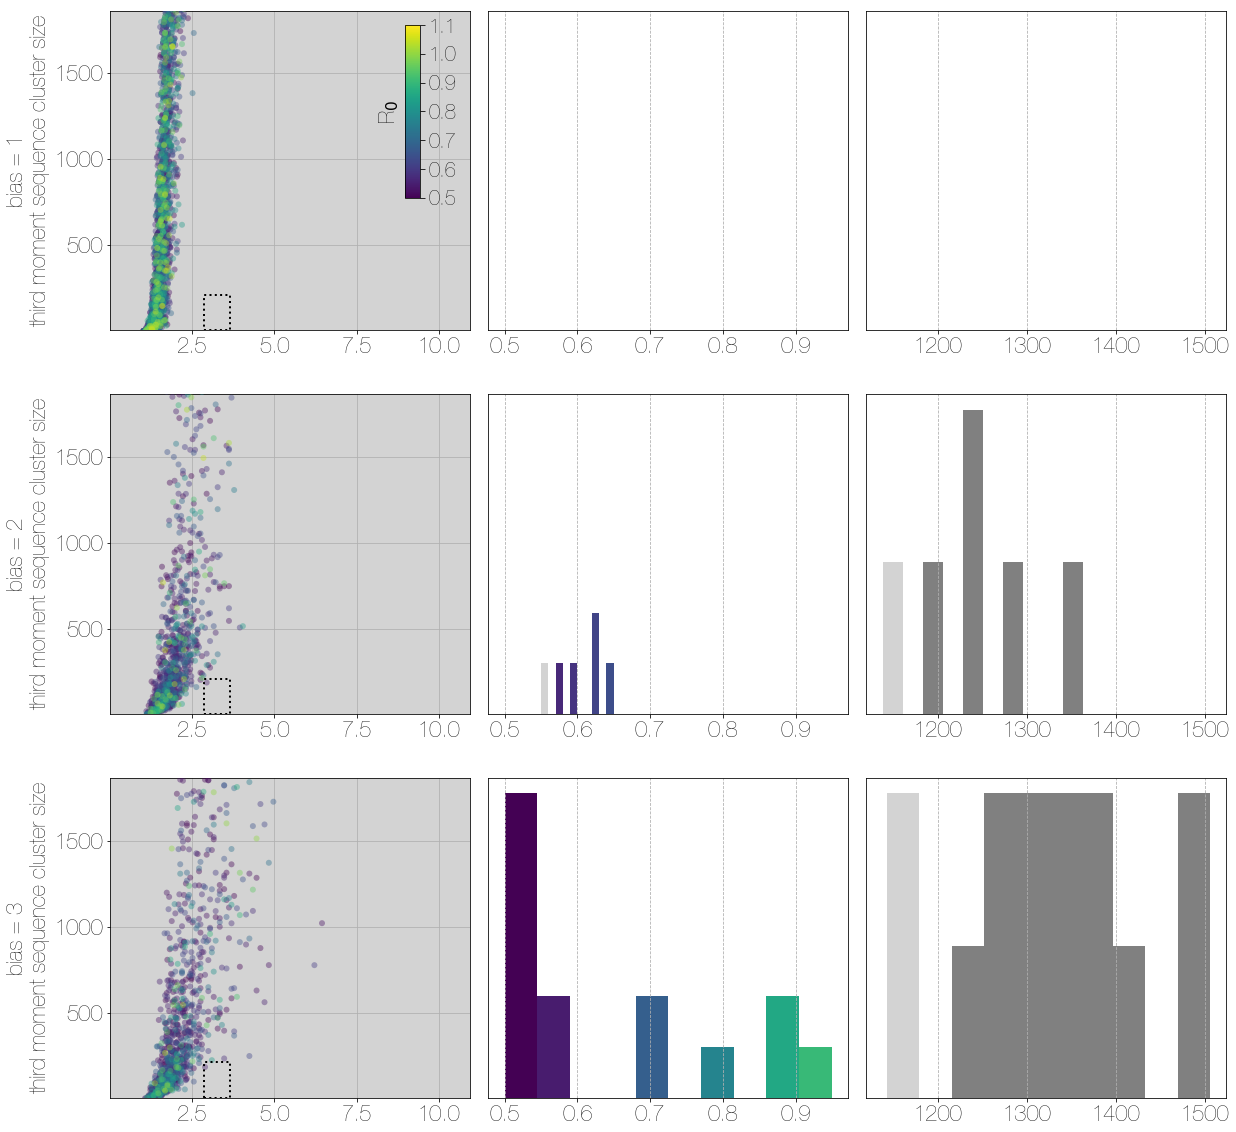

bias=1 dispersion=0.020
R0 percentiles: (0.61,0.87) median: 0.79 mean: 0.76 supporting sims: 4
introductions percentiles: (511,559) median: 532 mean: 534.25 supporting sims: 4
bias=2 dispersion=0.020
R0 percentiles: (0.50,0.80) median: 0.57 mean: 0.60 supporting sims: 286
introductions percentiles: (748,1083) median: 913 mean: 913.51 supporting sims: 286
bias=3 dispersion=0.020
R0 percentiles: (0.50,0.72) median: 0.57 mean: 0.58 supporting sims: 272
introductions percentiles: (785,1209) median: 981 mean: 988.97 supporting sims: 272
model averaged: 0.58 (0.50-0.72) 988.97 (783.25-1211.50)


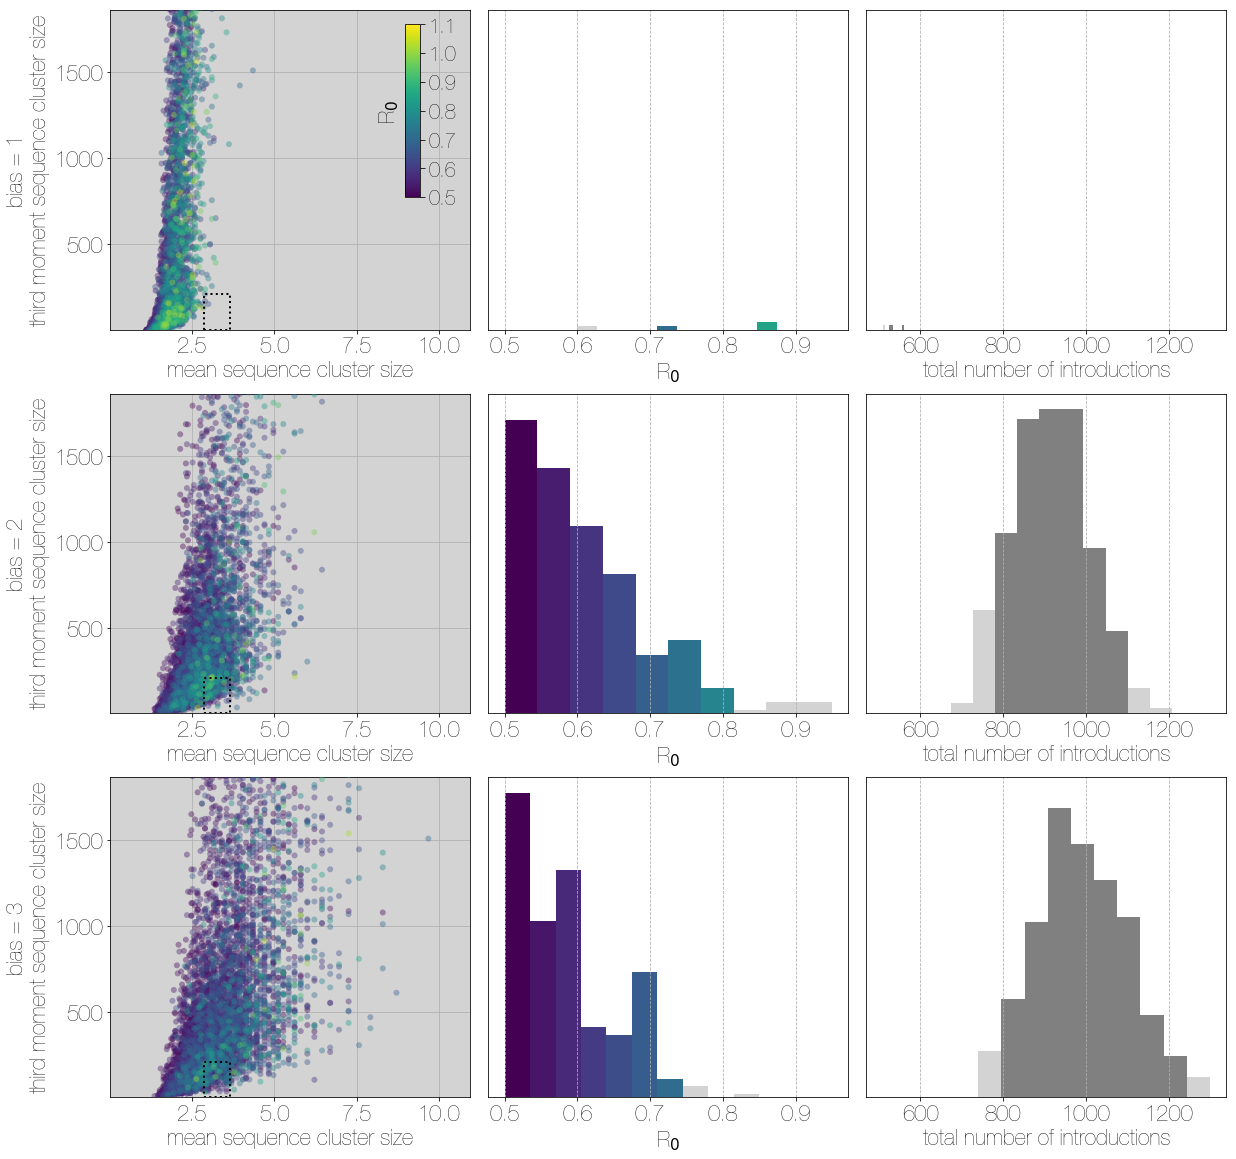

bias=1 dispersion=0.100
R0 percentiles: (0.72,1.00) median: 0.82 mean: 0.84 supporting sims: 121
introductions percentiles: (268,424) median: 344 mean: 348.84 supporting sims: 121
bias=2 dispersion=0.100
R0 percentiles: (0.60,0.88) median: 0.72 mean: 0.73 supporting sims: 594
introductions percentiles: (431,730) median: 563 mean: 570.37 supporting sims: 594
bias=3 dispersion=0.100
R0 percentiles: (0.55,0.82) median: 0.68 mean: 0.68 supporting sims: 552
introductions percentiles: (496,863) median: 652 mean: 658.49 supporting sims: 552
model averaged: 0.68 (0.55-0.82) 658.49 (496.38-863.62)


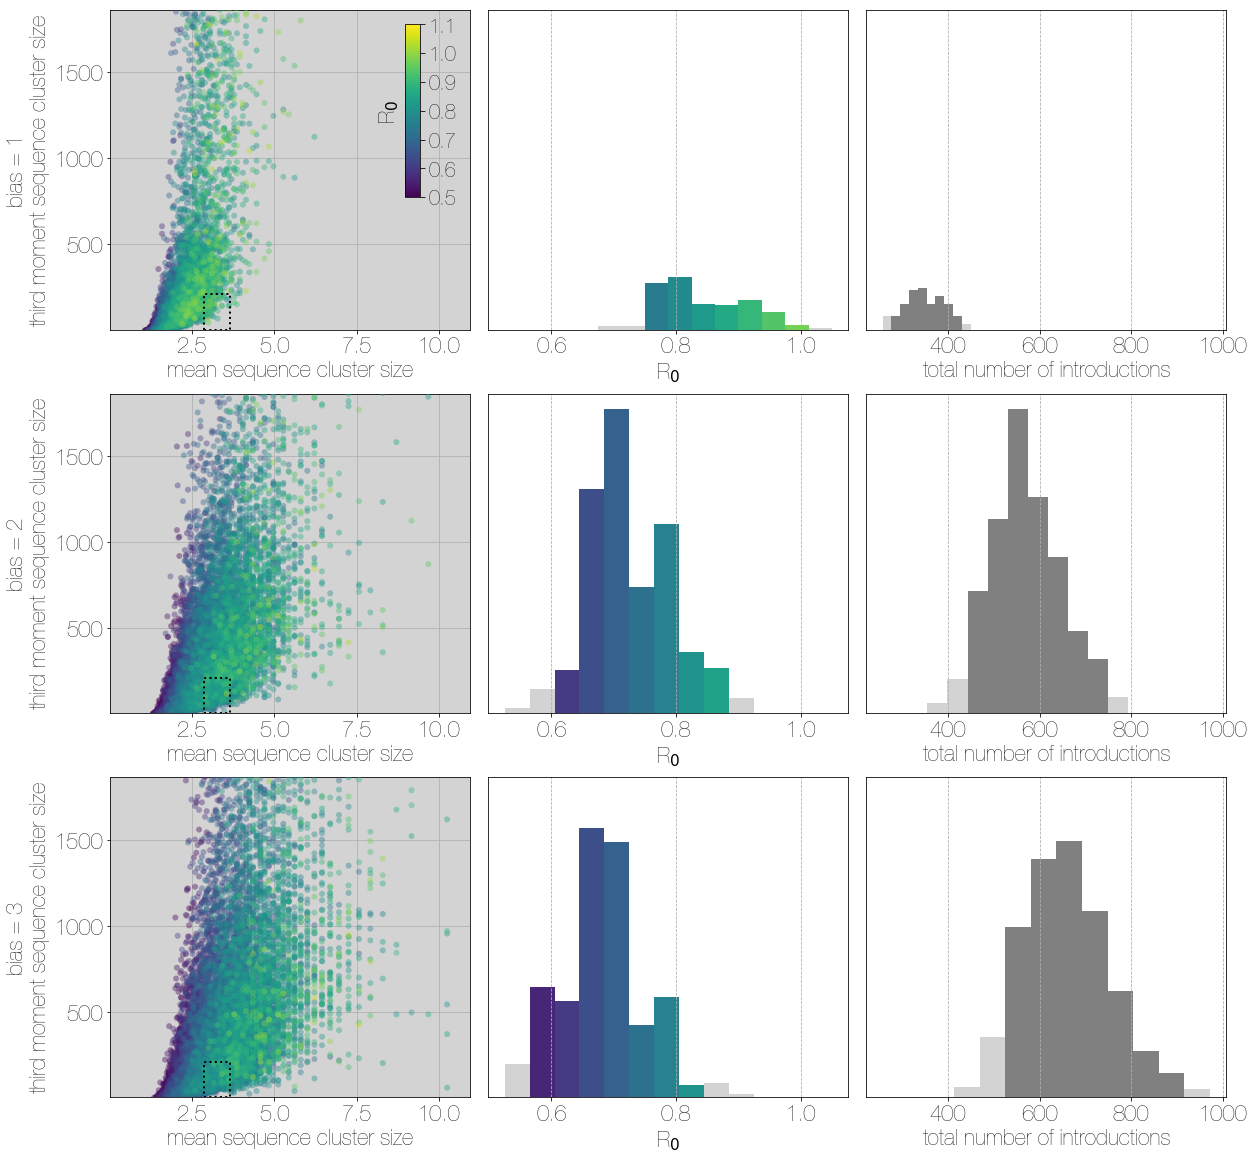

bias=1 dispersion=0.500
R0 percentiles: (0.82,0.98) median: 0.90 mean: 0.89 supporting sims: 377
introductions percentiles: (179,294) median: 234 mean: 234.19 supporting sims: 377
bias=2 dispersion=0.500
R0 percentiles: (0.75,0.93) median: 0.85 mean: 0.84 supporting sims: 329
introductions percentiles: (251,438) median: 337 mean: 336.88 supporting sims: 329
bias=3 dispersion=0.500
R0 percentiles: (0.74,0.90) median: 0.80 mean: 0.81 supporting sims: 308
introductions percentiles: (278,507) median: 385 mean: 384.82 supporting sims: 308
model averaged: 0.81 (0.73-0.90) 384.82 (278.00-508.85)


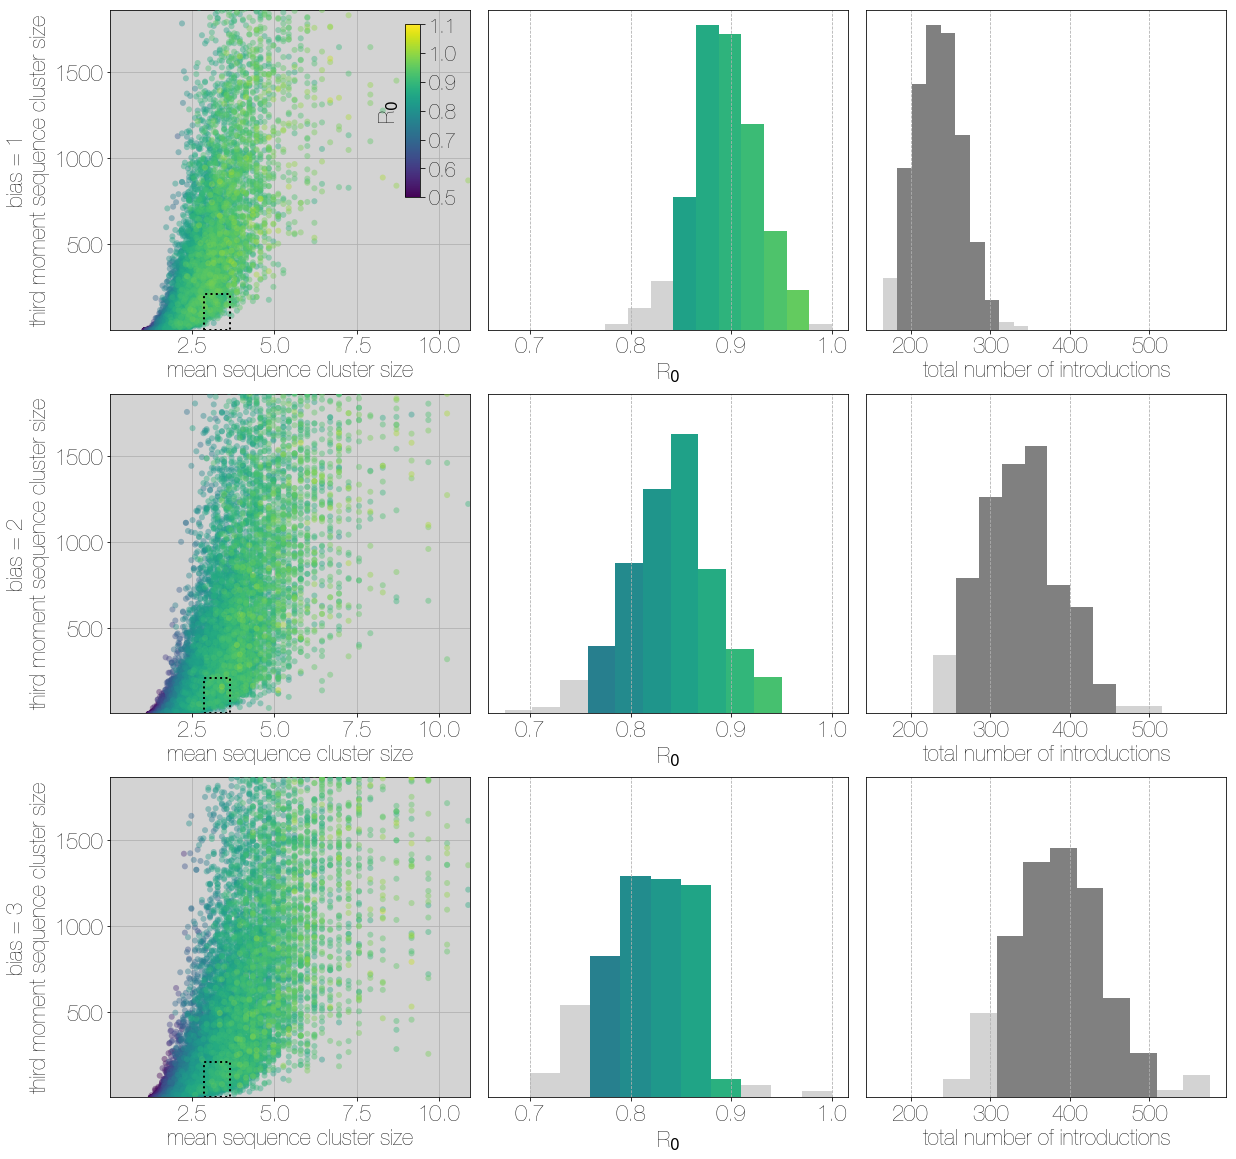

bias=1 dispersion=1.000
R0 percentiles: (0.85,0.97) median: 0.90 mean: 0.90 supporting sims: 348
introductions percentiles: (158,264) median: 207 mean: 207.63 supporting sims: 348
bias=2 dispersion=1.000
R0 percentiles: (0.80,0.93) median: 0.85 mean: 0.86 supporting sims: 301
introductions percentiles: (210,365) median: 284 mean: 285.94 supporting sims: 301
bias=3 dispersion=1.000
R0 percentiles: (0.78,0.93) median: 0.85 mean: 0.84 supporting sims: 266
introductions percentiles: (235,442) median: 314 mean: 321.05 supporting sims: 266
model averaged: 0.84 (0.78-0.93) 321.05 (232.00-446.00)


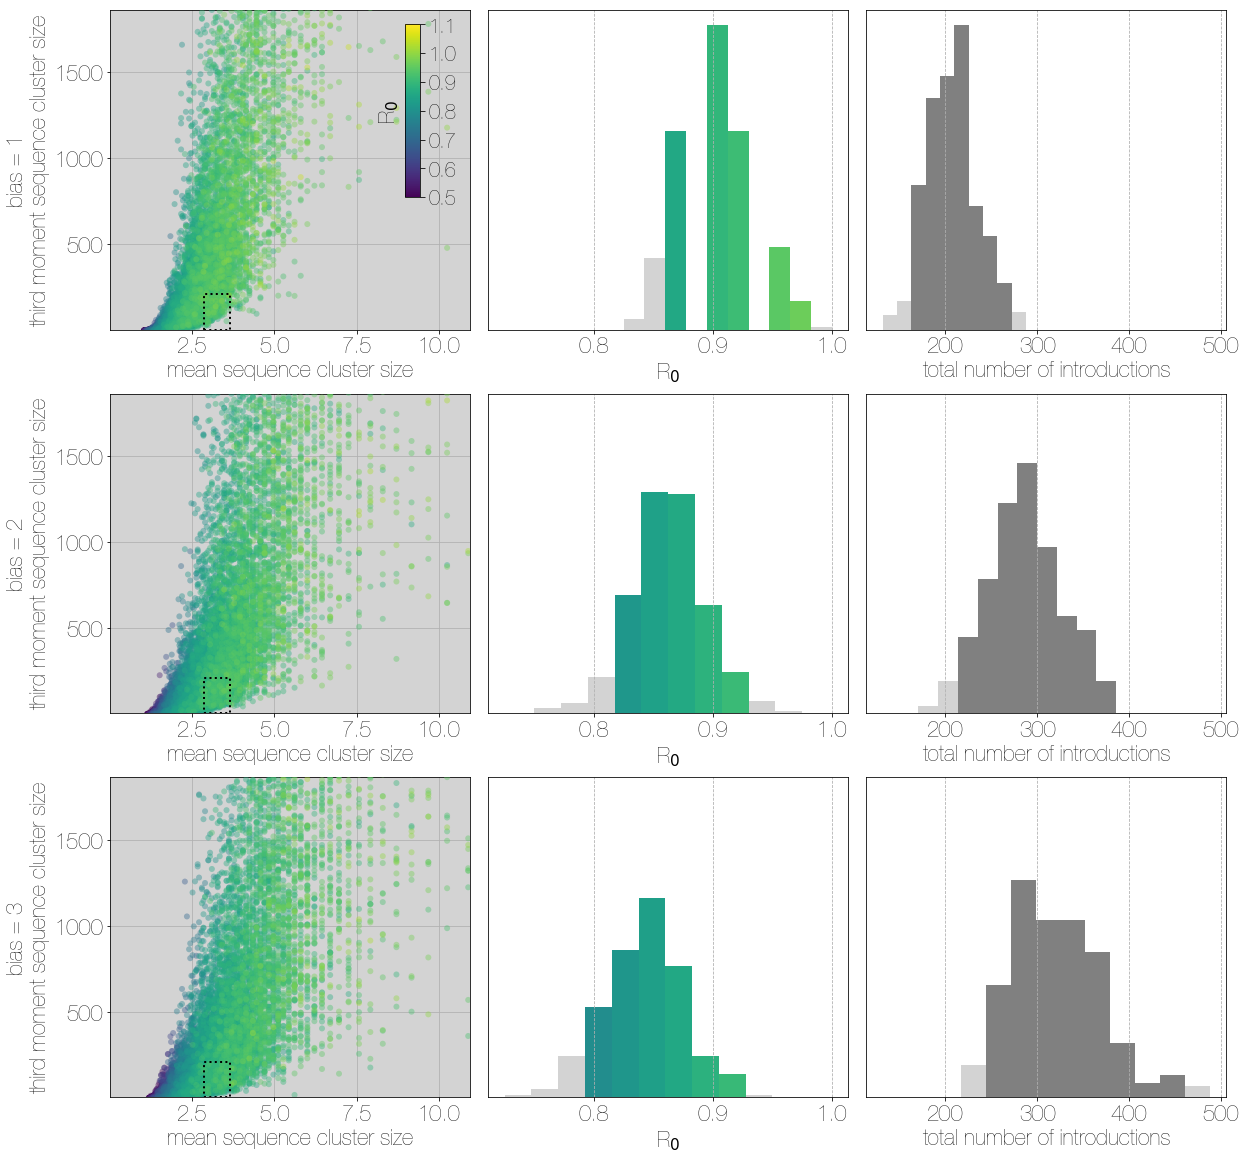

In [6]:
for k in ['0.004','0.020','0.100','0.500','1.000']:
    fig = plt.figure(figsize=(20,20),facecolor='w')
    gs = gridspec.GridSpec(3, 3,width_ratios=[1,1,1],hspace=0.20,wspace=0.05)

    ax1=plt.subplot(gs[0,0])
    ax1.set_facecolor('lightgrey')
    ax2=plt.subplot(gs[0,1])
    ax3=plt.subplot(gs[0,2])

    bx1=plt.subplot(gs[1,0],sharex=ax1)
    bx1.set_facecolor('lightgrey')
    bx2=plt.subplot(gs[1,1],sharex=ax2,sharey=ax2)
    bx3=plt.subplot(gs[1,2],sharex=ax3,sharey=ax3)

    cx1=plt.subplot(gs[2,0],sharex=ax1)
    cx1.set_facecolor('lightgrey')
    cx2=plt.subplot(gs[2,1],sharex=ax2,sharey=ax2)
    cx3=plt.subplot(gs[2,2],sharex=ax3,sharey=ax3)
    
    
    for bias in sorted(data.keys()):
        print 'bias=%s dispersion=%s'%(bias,k)
        if bias==1:
            zx1,zx2,zx3=ax1,ax2,ax3
        elif bias==2:
            zx1,zx2,zx3=bx1,bx2,bx3
        else:
            zx1,zx2,zx3=cx1,cx2,cx3

        intros=[]

        sl,su=hpds['std']
        ml,mu=hpds['mean']
        tl,tu=hpds['third']

        match_rectangle=plt.Rectangle((ml,sl),mu-ml,tu-tl,facecolor='none',edgecolor='k',lw=2,ls=':',zorder=10000)
#         match_rectangle=plt.Rectangle((sl,tl),su-sl,tu-tl,facecolor='none',edgecolor='k',lw=2,ls=':',zorder=10000)
        zx1.add_patch(match_rectangle)

        cmap=mpl.cm.viridis

        R0s=[]
        for r in matches[bias][k].keys():
#             xs=[x[0] for x in matches[bias][k][r]] ## means
            xs=[x[1] for x in matches[bias][k][r]] ## stdevs
            ys=[x[3] for x in matches[bias][k][r]] ## third moments
            intros+=[x[-2] for x in matches[bias][k][r]] ## intros

            zx1.scatter(xs,ys,facecolor=cmap(norm(float(r))),edgecolor='none',alpha=0.4,
                      zorder=int(float(r)*1000))
            R0s+=[float(r) for x in xs] ## store R0 values
        
        if len(R0s)>0:
            lc,uc=np.percentile(R0s,[2.5,97.5])
            n,bins,patches=zx2.hist(R0s,bins=10,facecolor='grey')

            print 'R0 percentiles: (%.2f,%.2f) median: %.2f mean: %.2f supporting sims: %d'%(lc,uc,np.median(R0s),np.mean(R0s),sum(n))

            for b,p in zip(bins,patches):
                if b<lc or b>uc:
                    p.set_facecolor('lightgrey')
                else:
                    p.set_facecolor(cmap(norm(b)))

            li,ui=np.percentile(intros,[2.5,97.5])
            n,bins,patches=zx3.hist(intros,bins=10,facecolor='grey')

            print 'introductions percentiles: (%d,%d) median: %d mean: %.2f supporting sims: %d'%(li,ui,np.median(intros),np.mean(intros),sum(n))


            for b,p in zip(bins,patches):
                if b<li or b>ui:
                    p.set_facecolor('lightgrey')

        for r in mismatches[bias][k].keys():
#             xs=[x[0] for x in mismatches[bias][k][r]] ## means
            xs=[x[1] for x in mismatches[bias][k][r]] ## stdevs
            ys=[x[3] for x in mismatches[bias][k][r]] ## third moments
            zx1.scatter(xs,ys,facecolor=cmap(norm(float(r))),edgecolor='none',alpha=0.4,
                       zorder=int(float(r)*1000))

        zx1.set_xlim(ml*0.01,mu*3.0)
        zx1.set_ylim(tl*0.01,tu*3.0)

        zx1.grid()
        zx2.grid(axis='x',ls='--')
        zx3.grid(axis='x',ls='--')

        #zx1.set_ylabel('bias = %d\nsequence cluster st dev'%(idx))
        zx1.set_ylabel('bias = %d\nthird moment sequence cluster size'%(bias))

        if idx==3:
            zx1.set_xlabel('mean sequence cluster size')
            zx2.set_xlabel('R$_{0}$')
            zx3.set_xlabel('total number of introductions')

        zx2.set_yticklabels([])
        zx3.set_yticklabels([])

        zx2.tick_params(axis='y',size=0)
        zx3.tick_params(axis='y',size=0)

    averaged_R0=[]
    averaged_intros=[]

    for idx in sorted(data.keys()):   
        for r in matches[bias][k].keys():
            xs=[x[1] for x in matches[bias][k][r]] ## mus

            averaged_intros+=[x[-2] for x in matches[bias][k][r]] ## intros
            averaged_R0+=[float(r) for x in xs]
    
    rl,ru=np.percentile(averaged_R0,[2.5,97.5])
    il,iu=np.percentile(averaged_intros,[2.5,97.5])
    print 'model averaged: %.2f (%.2f-%.2f) %.2f (%.2f-%.2f)'%(np.mean(averaged_R0),rl,ru,np.mean(averaged_intros),il,iu)

    cb = fig.add_axes([0.33, 0.75, 0.01, 0.12])
    mpl.colorbar.ColorbarBase(cb, cmap=cmap,ticks=np.linspace(0.5,1.1,7),norm=norm)
    cb.tick_params(size=5,labelsize=20)
    cb.yaxis.set_label_position('left')
    cb.set_ylabel('R$_{0}$')
    
    plt.show()

[1, 2, 3] [0.004, 0.02, 0.1, 0.5, 1.0]


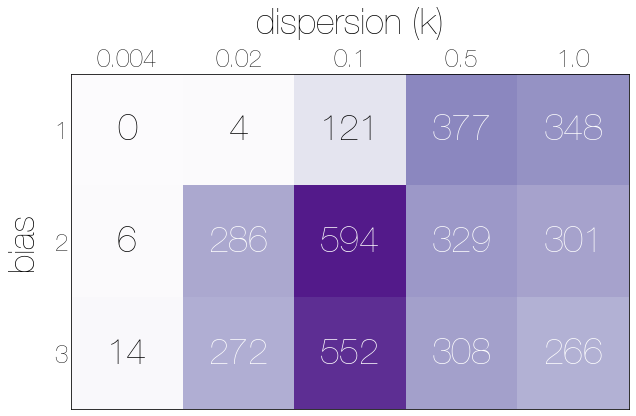

In [9]:
Bs=sorted(data.keys())
Ks=sorted(map(float,data[1].keys()))
print Bs,Ks

hmap=[[0.0 for k in Ks] for b in Bs]

for b,B in enumerate(data.keys()):
    for k,K in enumerate(sorted(data[bias].keys(),key=lambda x:float(x))):
        hmap[b][k]=sum([len(matches[B][K][r]) for r in data[B][K].keys()])
            
fig, ax = plt.subplots(figsize=(10,10))

cmap=mpl.cm.Purples
cmap.set_bad(color='k')

cax = ax.imshow(np.array(hmap), interpolation='nearest', cmap=cmap,alpha=0.9)
for i in range(len(Bs)):
    for j in range(len(Ks)):
        tc='k'
        if hmap[i][j]>150:
            tc='w'
        ax.text(j,i,'%s'%(hmap[i][j]),horizontalalignment='center',verticalalignment='center',size=36,color=tc)

ax.set_ylabel('bias',name=typeface,size=36,labelpad=15)
ax.set_xlabel('dispersion (k)',name=typeface,size=36,labelpad=15)

ax.set_yticks(range(len(Bs)))
ax.set_xticks(range(len(Ks)))

ax.set_yticklabels(Bs,size=24)
ax.set_xticklabels(Ks,size=24)

ax.tick_params(axis='y',which='both',direction='out',size=0,width=1)
ax.tick_params(axis='x',which='both',direction='out',size=0,width=1)

ax.xaxis.tick_top()
ax.yaxis.tick_left()
ax.xaxis.set_label_position('top') 

plt.savefig('/Users/evogytis/Documents/structured-mers/figures/mers_simMarginals.png',dpi=300,bbox_inches='tight')
plt.show()